In [1]:
%matplotlib notebook

In [42]:
from microphone import record_audio
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Audio
import librosa

from numba import njit
import numpy as np
import pickle
import time
import math

from music21 import *
import pygame as pg

from sklearn.cluster import KMeans

In [4]:
us = environment.UserSettings()
us.getSettingsPath()
environment.set('musescoreDirectPNGPath', "C:/Program Files/MuseScore 3/bin/MuseScore3.exe")

Getting User Input

In [22]:
def micRecord(time=10):
    frames, rate = record_audio(time)
    return np.hstack([np.frombuffer(i, np.int16) for i in frames]), rate
def getFile(path):
    recorded_audio, sampling_rate = librosa.load(path, 
                                                 sr=44100, 
                                                 mono=True,
                                                duration=20)
    return recorded_audio, sampling_rate
def pressure(times: np.ndarray, *, amp: float, freq: float) -> np.ndarray:
    return amp * np.sin(2 * np.pi * freq * times)
def pureTone(freq, amp=0.06, dur=3, rate=44100):
    n_samples = int(dur * rate) + 1
    times = np.arange(n_samples) / rate  # seconds
    return pressure(times, amp=amp, freq=freq), rate  # Pascals

In [6]:
def userinput():
    while True:
        audioType = input("u for Upload, r for Record: ")
        if audioType == 'u':
            path = input("Enter path to file: ")
            samples, rate = getFile(path)
            break
        elif audioType == 'r':
            samples, rate = micRecord()
            break
        print("Invalid input. Try again.")
    # print(rate)
    
    return samples, rate

Processing

In [7]:
def getspec(samples, rate):
    spectrogram, freqs, times = mlab.specgram(
		samples,
		NFFT=4096,
		Fs=rate,
		window=mlab.window_hanning,
		noverlap=int(4096 / 2)
	)
    return spectrogram, freqs, times

In [68]:
def distinctFreqs(freq1:float, freq2:float, a=1.05):
    larger_freq = max(freq1, freq2)
    smaller_freq = min(freq1, freq2)
    if smaller_freq == 0:
        smaller_freq = 1e-100
    if math.isclose(larger_freq/smaller_freq, 2, rel_tol = 0.03):
        return False
    if larger_freq/smaller_freq >= a:
        return True
    else:
        return False

In [63]:
def convert(freqTimes: dict):
    #returns a list of lists [freq, start, last seen instance, duration]
    freqDurations = []
    
    # key and value for the original dictionary
    for time, freqs in freqTimes.items():
        
        # each frequency in this current key of the dictionary
        for f in freqs: 
            if f==0:
                continue
            #GOING THROUGH THE PREVIOUS LAYER
            # the default index of the current list item is the very last index (assuming it appends one)
            currentListIndex = len(freqDurations)
#             print("currListIndex at first= " + str(currentListIndex))
            
            # each index of the durations list
            previouslyFound = False
            for fd in range(0, len(freqDurations)):
                fd_item = freqDurations[fd]
                
                # if time is 0, will always return false
                if not distinctFreqs(fd_item[0], f) and fd_item[2] == time-1:
#                     print(fd_item[0], f)
                    currentListIndex = fd
#                     print("found in previous layer")
                    previouslyFound = True
                
                # current list item is the index of this newly added item
            if not previouslyFound:
                freqDurations.append([f, time, time, 1])
                    
            if (len(freqDurations) == 0):
                freqDurations.append([f, time, time, 1])
            
#             print("before: ")
#             print(freqDurations)
                    
            #GOING THROUGH THE NEXT LAYER
            # each frequency in the next key of the dictionary
            if (time + 1) < len(freqTimes):
                for next_freq in freqTimes[time+1]:
                    if not(distinctFreqs(f, next_freq)):
#                         print("not distinct: " + str(f) + "  " + str(next_freq))
#                         avg = (f + next_freq)/2
                        mini = min(f, next_freq)
                        # updates the frequency, changes the last seen instance, and adds 1 to the duration
#                         print("currListIndex= " + str(currentListIndex))
                        freqDurations[currentListIndex] = [mini, freqDurations[currentListIndex][1], 
                                                          time, freqDurations[currentListIndex][3] + 1]
                        #print(freqDurations[currentListIndex])
#             print("after: ")
#             print(freqDurations)
#             print()
#     print(freqDurations)            
    return freqDurations

In [10]:
def groupDuration(freqDurations: list, num_clusters: int, max_duration_num = 5):
    #returns list of cluster ids
    
    data = np.array([item[3] for item in freqDurations]).reshape(-1,1)
    kmeans = KMeans(num_clusters)
    kmeans.fit(data)
    
    clusters = kmeans.fit_predict(data)
    #print(clusters)
    
    wcss=[]
#     for i in range(1,max_duration_num):
#         kmeans = KMeans(i)
#         kmeans.fit(data)
#         wcss_iter = kmeans.inertia_
#         wcss.append(wcss_iter)

    number_clusters = range(1, max_duration_num)
#     plt.plot(number_clusters,wcss)
#     plt.title('The Elbow title')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('WCSS')
    
    return clusters, num_clusters

In [11]:
def durations(num_clusters: int):
    #returns list of durations
    quarter_index = int(num_clusters/2) 
    
    durationMappingKey = [0.166, 0.5, 1, 2, 4]
    
    duration_list = []
    start = 2 - quarter_index
    for i in range(start, start + num_clusters):
        duration_list.append(durationMappingKey[i])
        
    return duration_list

In [33]:
def notes(freqDurations: list, clusterIDs: list, duration_list: list):
    #return list of notes
    #normFreqs = music21.audioSearch.detectPitchFrequencies([freq[0] for freq in freqDurs])
    notes = []
    for freqIndex in range(len(freqDurations)):
        print(freqDurations[freqIndex][0])
        p = pitch.Pitch()
        p.frequency = freqDurations[freqIndex][0]
        n = note.Note(pitchName = p.name)
        d = duration.Duration()
        print(duration_list[clusterIDs[freqIndex]])
        d.quarterLength = duration_list[clusterIDs[freqIndex]]
        n.duration = d
        
        notes.append(n)
#     print(normFreqs)
    print(notes)
    return notes

In [38]:
def streamNotes(notes: list):
    s = stream.Stream()
    for n in notes:
        s.append(n)
#     mf = midi.translate.streamToMidiFile(s)
    s.show()
    sp = midi.realtime.StreamPlayer(s, playForMilliseconds = 5000)
    sp.play()
#     return mf

In [23]:
def sheetMusic(peak_dict: dict, num_clusters: int):
    print(peak_dict)
    freqDurs = convert(peak_dict)
    print(freqDurs)
    
    clusterIDs, num_clusters = groupDuration(freqDurs, num_clusters = num_clusters, max_duration_num = 5)
    
    duration_list = durations(num_clusters)
    
    notesList = notes(freqDurs, clusterIDs, duration_list)
    streamNotes(notesList)

In [15]:
def find_min_amp(maxamps, amp_threshold):
    ind = round(len(maxamps) * amp_threshold)
    cutoff_log_amplitude = np.partition(maxamps, ind)[ind]
    return cutoff_log_amplitude

u for Upload, r for Record: u
Enter path to file: C:\Users\ejian\CogWorks-2022-Gausslien-Audio-Capstone\Songs2\Twinkle-twinkle-little-star-piano.mp3


C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


{0: [527.5634765625], 1: [527.5634765625], 2: [527.5634765625], 3: [527.5634765625], 4: [527.5634765625], 5: [527.5634765625], 6: [527.5634765625], 7: [527.5634765625], 8: [527.5634765625], 9: [527.5634765625], 10: [527.5634765625], 11: [527.5634765625], 12: [516.796875], 13: [527.5634765625], 14: [527.5634765625], 15: [527.5634765625], 16: [527.5634765625], 17: [527.5634765625], 18: [527.5634765625], 19: [527.5634765625], 20: [527.5634765625], 21: [527.5634765625], 22: [527.5634765625], 23: [527.5634765625], 24: [527.5634765625], 25: [527.5634765625], 26: [527.5634765625], 27: [527.5634765625], 28: [527.5634765625], 29: [0.0], 30: [785.9619140625], 31: [785.9619140625], 32: [785.9619140625], 33: [785.9619140625], 34: [785.9619140625], 35: [785.9619140625], 36: [785.9619140625], 37: [785.9619140625], 38: [785.9619140625], 39: [785.9619140625], 40: [0.0], 41: [0.0], 42: [0.0], 43: [785.9619140625], 44: [0.0], 45: [785.9619140625], 46: [785.9619140625], 47: [785.9619140625], 48: [785.961

C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


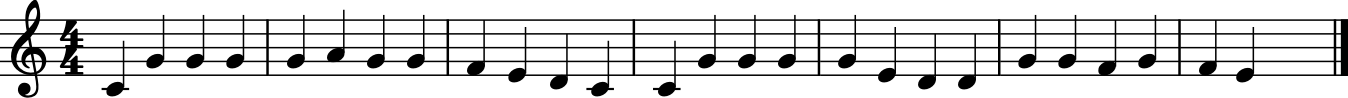

In [69]:
#music, sampling_rate = pureTone(261.63)
music, sampling_rate = userinput()
spec, freq, time = getspec(music, sampling_rate)

maxamps = np.log(np.max(spec,axis=0))
maxfreqs = np.argmax(spec, axis=0)
maxfreqs = freq[maxfreqs]
#print(maxfreqs)
thresh = find_min_amp(maxamps,0.1)
comps = maxamps>thresh
zeroedfreqs = np.trim_zeros(comps*maxfreqs)

timefreq = [(i,[j]) for i,j in enumerate(zeroedfreqs)]
timefreq = dict(timefreq)

sheetMusic(timefreq, num_clusters = 1)